In [8]:
import os

import pandas as pd
from pandas.errors import EmptyDataError 

import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta, timezone
from datetime import date as dt
import dateutil.parser as dparser
import pytz

In [9]:
# Given parameters:
# 1) Date in the form (YYYYMMDD)
# 2) Time in the form (HHMMSS)
# 4) det_type can either be 'LF' or 'HF'

# Output:
# The table of selections. 
# - Column 1 is start time of selection within file
# - Column 2 is end time of selection within file
# - Column 3 is lowest frequency of selection within file
# - Column 3 is highest frequenct of selection within file
# Length of selections will give us # of selections

def getData(date, time, det_type):
    date_n_type_path = '/' + date + '/' + date + '_' + det_type + 'detections'

    source_dir = 'Selections' + date_n_type_path

    file_name = (det_type + date + '_' + time + '.WAV.txt')
    file_path = source_dir + '/' + file_name
    sels_np = np.array([])
    
    if (os.path.exists(file_path)):
        try:
            data = pd.read_csv(file_path, sep='\t')
        except EmptyDataError:
            print(file_path + " is empty")

        sels_np = data.to_numpy()[::2, 3:-1:]

    return sels_np

In [49]:
# These are variables that will help us point to specific folders and files

# Session name is the folder name where our recordings are
session_name = ''

# Sorted_files is our list of all recording file names within a single folder
session_dir = session_name+'Recordings'
files = os.listdir(session_dir)
sorted_files = sorted(files)

# We fill the first 3 columns of our dataframe right here using dateutils parser
dates = []
s_times = []
e_times = []
for file in sorted_files:
    dates.append(str(dparser.parse(file, fuzzy=True).date()))
    s_times.append(str(dparser.parse(file, fuzzy=True).time()))
    e_times.append(str(((dparser.parse(file, fuzzy=True)) + (timedelta(minutes=29, seconds=55))).time()))

# We fill out the next 2 columns of data regarding the number of LF and HF selections
num_LFselections = np.zeros(len(s_times))
num_HFselections = np.zeros(len(s_times))

for i, date in enumerate(dates):
    # We need to remove the - from YYYY-MM-DD which is standard datetime format.
    # This will help us find files in the YYYYMMDD standard Audiomoth format
    date = date.replace('-', '')
    # Same goes for the HH:MM:SS standard datetime format and the Audiomoth's HHMMSS standard
    time = s_times[i].replace(":", "")
    
    LFfile_selections = getData(date, time, 'LF')
    num_LFselections[i] = len(LFfile_selections)
    
    HFfile_selections = getData(date, time, 'HF')
    num_HFselections[i] = len(HFfile_selections)

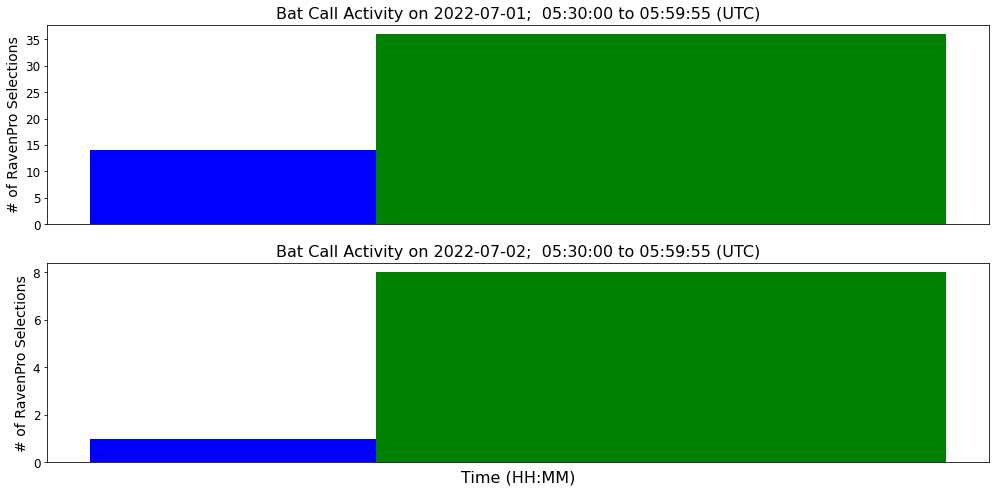

In [14]:
# Intiailize x_ticks
n_bins = len(num_LFselections)
ticks = np.arange(0, n_bins)/2.0 + 2

# There will be 23 recordings in range 02:00 to 13:00 (1 day)
num_times = 1 # For now, let's try having 1 recording per day
num_days = n_bins//num_times

bar_width = 0.2

plt.rcParams['font.size'] = '12'
 
# There will be multiple days of data so we plot each day's data in a different subplot
if (num_days > 1):
    fig, ax = plt.subplots(num_days, 1, figsize =(14, 7), tight_layout = True)
    for i in range(num_days):

        # We format the bar graph and the distance each bar is from the specified time
        ax[i].bar(ticks[i*num_times:(i+1)*num_times]+(bar_width), 
                  num_LFselections[i*num_times:(i+1)*num_times], color = 'b', width = bar_width)
        ax[i].bar(ticks[i*num_times:(i+1)*num_times]+(3*bar_width/2), 
                  num_HFselections[i*num_times:(i+1)*num_times], color = 'g', width = bar_width)

        # Cut off the unnecessary time info from the start times so we can label the x-axis ticks
        xlabels = []
        for time in s_times:
            xlabels.append(time[:-3])

        # Use the labels from each specific day just like the rest of the data
        ax[i].set_xticks(ticks[i*num_times:(i+1)*num_times:])
        ax[i].set_xticklabels(xlabels[i*num_times:(i+1)*num_times:])

        # Set figure titles and y_labels. We let the x_label represent the same for both figures
        ax[i].set_title('Bat Call Activity on ' + dates[i*num_times] + ';  ' + s_times[i*num_times] + ' to ' + e_times[(i+1)*num_times-1] + ' (UTC)', fontsize=16)
        ax[i].set_ylabel('# of RavenPro Selections', fontsize=14)

    # Show plot
    plt.xlabel('Time (HH:MM)', fontsize=16)
    plt.show()
else:
    print('Go to next cell!')

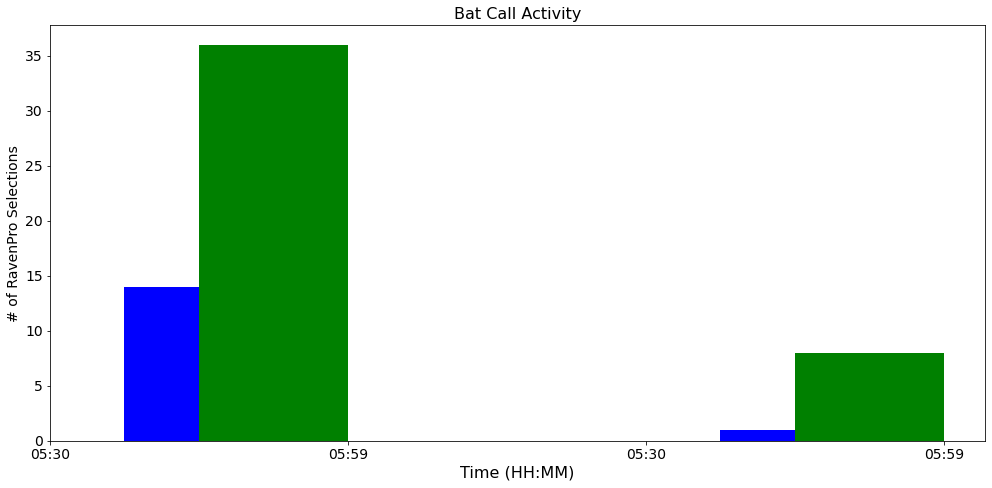

In [47]:
# This a histogram plot of all files from one deployment session

n_bins = len(num_LFselections)
ticks = np.arange(0, n_bins)/0.5

# The bar width is smaller to make room for all the bars
bar_width = 0.5

# The font size is smaller too
plt.rcParams['font.size'] = '14'
 
# Creating histogram
fig, ax = plt.subplots(1, 1, figsize =(14, 7), tight_layout = True)

ax.bar(ticks+(bar_width), num_LFselections, color = 'b', width = bar_width)
ax.bar(ticks+(3*bar_width/2), num_HFselections, color = 'g', width = bar_width)

xlabels = []
for i, time in enumerate(s_times):
    xlabels.append(time[:-3])
    xlabels.append(e_times[i][:-3])
    
ax.set_xticks(np.arange(0, 2*n_bins))
ax.set_xticklabels(xlabels[::])
ax.set_title('Bat Call Activity', fontsize=16)

ax.set_ylabel('# of RavenPro Selections', fontsize=14)
    
# Show plot
plt.xlabel('Time (HH:MM)', fontsize=16)
plt.show()

In [48]:
df = pd.DataFrame()

df["File Names"] = sorted_files
df["Date"] = dates  
df["Start (UTC)"] = s_times
df["End (UTC)"] = e_times
df["LF selections"] = num_LFselections
df["HF selections"] = num_HFselections

print(df)

            File Names        Date Start (UTC) End (UTC)  LF selections  \
0  20220701_053000.WAV  2022-07-01    05:30:00  05:59:55           14.0   
1  20220702_053000.WAV  2022-07-02    05:30:00  05:59:55            1.0   

   HF selections  
0           36.0  
1            8.0  
